In [31]:
# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib import ticker
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import wrf as wrfpy
from wrf import (to_np, getvar, ALL_TIMES, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

# Import the pvlib module
if sys.platform == 'linux':
    sys.path.append('/home/jsward/Documents/01_Research/01_Renewable_Analysis/WRF/pvlib-python')
else:
    sys.path.append('/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python')
import pvlib
from pvlib.wrfcast import WRF

# Import the optwrf module
import optwrf
from optwrf import runwrf
from optwrf import helper_functions as hf
from optwrf import plots as owplt

### Open the WRF and ERA5 NetCDF files

In [5]:
# Verbose setting
verbose = True

# Define the datestr and paramstr !!!!!!! REQUIRES CHANGE TO PLOT DIFFERENT SIM
datestr = '2011-12-13'
optwrf_paramstr = '19mp4lw4sw7lsm8pbl99cu'
ncarwrf_paramstr = '8mp4lw4sw2lsm2pbl6cu'
optwrffile_name = f'wrfout_processed_d01_{datestr}_{optwrf_paramstr}.nc'
ncarwrffile_name = f'wrfout_processed_d01_{datestr}_{ncarwrf_paramstr}.nc'

# Find the absolute file path to your optwrf package
optwrf_abspath = os.path.dirname(os.path.abspath(inspect.getfile(optwrf)))
optwrf_abspath

# Open the processed wrfout data !!!!!!! REQUIRES CHANGE TO PLOT DIFFERENT SIM
wrf_dir = os.path.join(optwrf_abspath, 'data/optwrf_sim/')
optwrffile = os.path.join(wrf_dir, optwrffile_name)
ncarwrffile = os.path.join(wrf_dir, ncarwrffile_name)
owds = xr.open_dataset(optwrffile)
nwds = xr.open_dataset(ncarwrffile)
if verbose:
    print(f'Processeed OptWRF DATA:\n{owds}\n')
    print(f'Processeed NCAR WRF DATA:\n{nwds}\n')
    
# Open the processed ERA5 data
era_dir = os.path.join(optwrf_abspath, 'data/ERA5/')
erafile = os.path.join(era_dir, 'ERA5_EastUS_WPD-GHI_2011-12.nc')
erads = xr.open_dataset(erafile)
if verbose:
    print(f'ERA5 DATA:\n{erads}')

Processeed OptWRF DATA:
<xarray.Dataset>
Dimensions:         (Time: 24, bottom_top: 35, south_north: 191, west_east: 191)
Coordinates:
  * Time            (Time) datetime64[ns] 2011-12-13 ... 2011-12-13T23:00:00
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times           (Time) datetime64[ns] ...
    temp_air        (Time, south_north, west_east) float32 ...
    wind_speed_u    (Time, south_north, west_east) float32 ...
    wind_speed_v    (Time, south_north, west_east) float32 ...
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith      (Time, south_north, west_east) float32 ...
    dni             (Time, south_north, west_east) float32 ...
    dhi             (Time, south_north, west_east) float32 ...
    ghi             (Time, south_north, west_east) float32 ...
    wind_speed10    (Time, so

/opt/anaconda3/envs/optwrf/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'pressure' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


### Now, plot the GHI values across d01 in three panels

In [6]:
# To start, we need to get the WRF map projection information (a Lambert Conformal grid),
# and find the domain boundaries in this projection.
# NOTE: this task MUST occurr before we regrid the WRF variables or the coordinates change and become incompatible.
wrf_cartopy_proj = owplt.get_wrf_proj(owds, 'dni')
proj_bounds = owplt.get_domain_boundary(owds, wrf_cartopy_proj)

ValueError: minvalue must be positive

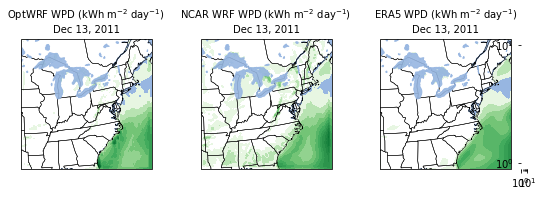

In [32]:
save_fig = False
fig_path = f'/Users/jsward/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/opt_ncar_era5_ghi_compare'

# Specify the variable you want to plot
var = 'wpd'

# Format the var input
if type(var) is not str:
    print(f'The var input, {var}, must be a string.')
    raise TypeError
if var in ['GHI', 'ghi']:
    var = 'ghi'
    wrf_var = 'ghi'
    era_var = 'GHI'
elif var in ['WPD', 'wpd']:
    var = 'wpd'
    wrf_var = 'wpd'
    era_var = 'WPD'
else:
    print(f'Variable {var} is not supported.')
    raise KeyError

# We can use a basic Plate Carree projection for ERA5
era5_cartopy_proj = ccrs.PlateCarree()

# Now, get the desired variables
# Define the time indicies from the times variable
time_indicies = range(0, len(owds.Time))
# Format the times for title slides
times_strings_f = owds.Time.dt.strftime('%b %d, %Y %H:%M')
# Get the desired variable(s)
for tidx in time_indicies:
    timestr = owds.Time[tidx].values
    timestr_f = times_strings_f[tidx].values
    time_string_f = owds.Time[0].dt.strftime('%b %d, %Y')
    title_str = f'{era_var} (kWh m$^{{-2}}$ day$^{{-1}}$) \n{time_string_f.values}'

    # WRF Variable (divide by 1000 to convert from W to kW or Wh to kWh)
    if tidx != 0:
        plot_owvar = plot_owvar + (owds[wrf_var].sel(Time=np.datetime_as_string(timestr)) / 1000)
        plot_nwvar = plot_nwvar + (nwds[wrf_var].sel(Time=np.datetime_as_string(timestr)) / 1000)
    else:
        plot_owvar = owds[wrf_var].sel(Time=np.datetime_as_string(timestr)) / 1000
        plot_nwvar = nwds[wrf_var].sel(Time=np.datetime_as_string(timestr)) / 1000

    # ERA5 GHI (divide by 1000 to convert from W to kW or Wh to kWh)
    if tidx != 0:
        plot_era5var = plot_era5var + (erads[era_var].sel(Time=timestr_f) / 1000)
    else:
        plot_era5var = erads[era_var].sel(Time=timestr_f) / 1000

# Create a figure
# fig = plt.figure(figsize=(6.5, 2.4))
fig = plt.figure(figsize=(9.75, 2.4))

# Set the GeoAxes to the projection used by WRF
ax_ow = fig.add_subplot(1, 3, 1, projection=wrf_cartopy_proj)
ax_nw = fig.add_subplot(1, 3, 2, projection=wrf_cartopy_proj, sharey=ax_ow)
ax_era5 = fig.add_subplot(1, 3, 3, projection=wrf_cartopy_proj, sharey=ax_nw)

# Make the countour lines for filled contours for the GHI
contour_levels = owplt.specify_contour_levels(var, hourly=False)

# Add the filled contour levels
color_map = owplt.specify_clormap(var)
ow_cn = ax_ow.contourf(wrfpy.to_np(owds.lon), wrfpy.to_np(owds.lat), wrfpy.to_np(plot_owvar),
                         contour_levels, locator=ticker.LogLocator(), transform=ccrs.PlateCarree(), cmap=color_map)
nw_cn = ax_nw.contourf(wrfpy.to_np(nwds.XLONG), wrfpy.to_np(nwds.XLAT), wrfpy.to_np(plot_nwvar),
                         contour_levels, locator=ticker.LogLocator(), transform=ccrs.PlateCarree(), cmap=color_map)
era5_cn = ax_era5.contourf(wrfpy.to_np(erads.longitude), wrfpy.to_np(erads.latitude), wrfpy.to_np(plot_era5var),
                           contour_levels, locator=ticker.LogLocator(), transform=era5_cartopy_proj, cmap=color_map)

# Format the plots
owplt.format_cnplot_axis(ax_ow, ow_cn, proj_bounds,
                         title_str=f'OptWRF {title_str}', add_colorbar=False)
owplt.format_cnplot_axis(ax_nw, nw_cn, proj_bounds,
                         title_str=f'NCAR WRF {title_str}', add_colorbar=False)
owplt.format_cnplot_axis(ax_era5, era5_cn, proj_bounds,
                         title_str=f'ERA5 {title_str}', add_colorbar=False)

# Add a color bar to the full plot
# cbar_tick_labels = ['0', '1', '2', '3', '4', '5']
# cbar_tick_labels=['0', '5000', '10000', '15000', '20000', '25000', '30000', '35000']
# cbar_ticks = [0, 1, 2, 3, 4, 5]
# cbar_ticks = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000]
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.85,  # increasing this past 0.85 moves the colorbar to the right
                        0.125,  # increasing this moves the colorbar up
                        0.01,  # increasing this increases the thickness of the colorbar
                        0.75  # increasing this increases the height of the colorbar
                       ])
cbar = fig.colorbar(era5_cn, cax=cbar_ax,
                    ticks=cbar_ticks,
                    )
cbar.ax.set_yticklabels(cbar_tick_labels)  # vertically oriented colorbar

# Save the figure
if save_fig:
    file_type = '.png'
    plt.savefig(fig_path + file_type, dpi=300, transparent=True, bbox_inches='tight')
plt.show()